In [103]:
library(tidyverse)
library(magrittr)
library(readxl)
library(lme4)
library(emmeans)

In [104]:
exp1 = read_xlsx('CLICK-it_WB_cumulative_LCLs.xlsx', sheet=1)

In [105]:
head(exp1)

Gel,Genotype,Sample,Treatment,TAMRA,BetaActin,Background
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,AA,HG01112,Vehicle,81.42,9.044,0.002
1,AA,HG01112,Vehicle,70.22,8.711,0.002
1,AA,HG01112,Vehicle,68.05,8.363,0.002
1,AA,HG01112,Thapsi,27.08,10.176,0.002
1,AA,HG01112,Thapsi,30.90,10.219,0.002
1,AA,HG01112,Thapsi,35.83,9.784,0.002


In [106]:
exp2 = read_xlsx('CLICK-it_WB_cumulative_LCLs.xlsx', sheet=2)

In [107]:
head(exp2)

Gel,Genotype,Sample,Treatment,TAMRA,BetaActin,Background
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,AA,HG01932,Vehicle,109.16,8.949,0.431
1,AA,HG01932,Vehicle,109.00,9.232,0.431
1,AA,HG01932,Vehicle,108.88,8.651,0.431
1,AA,HG01932,Thapsi,45.41,8.341,0.431
1,AA,HG01932,Thapsi,47.33,8.482,0.431
1,AA,HG01932,Thapsi,52.55,7.780,0.431


In [108]:
exp1 %<>% mutate(Experiment = "Exp1")
exp2 %<>% mutate(Experiment = "Exp2", Gel = Gel + 3)

df = rbind(exp1, exp2)

head(df)

Gel,Genotype,Sample,Treatment,TAMRA,BetaActin,Background,Experiment
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,AA,HG01112,Vehicle,81.42,9.044,0.002,Exp1
1,AA,HG01112,Vehicle,70.22,8.711,0.002,Exp1
1,AA,HG01112,Vehicle,68.05,8.363,0.002,Exp1
1,AA,HG01112,Thapsi,27.08,10.176,0.002,Exp1
1,AA,HG01112,Thapsi,30.90,10.219,0.002,Exp1
1,AA,HG01112,Thapsi,35.83,9.784,0.002,Exp1


In [109]:
df %<>%
    group_by(Experiment) %>%
    mutate(TAMRA_ = TAMRA-Background,
           BetaActin_ = BetaActin-Background,
           NormFactor = BetaActin_/max(BetaActin_),
           NormSignal = TAMRA_/NormFactor,
           Experiment = factor(Experiment, levels = c("Exp1", "Exp2")),
           Genotype = factor(Genotype, levels = c("AA", "CC", "EIF2B2")),
           Treatment = factor(Treatment, levels = c("Vehicle", "Thapsi"))) %>%
    ungroup()

In [110]:
head(df)

Gel,Genotype,Sample,Treatment,TAMRA,BetaActin,Background,Experiment,TAMRA_,BetaActin_,NormFactor,NormSignal
<dbl>,<fct>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,AA,HG01112,Vehicle,81.42,9.044,0.002,Exp1,81.42,9.042,0.5050,161.21
1,AA,HG01112,Vehicle,70.22,8.711,0.002,Exp1,70.22,8.709,0.4864,144.36
1,AA,HG01112,Vehicle,68.05,8.363,0.002,Exp1,68.05,8.361,0.4670,145.72
1,AA,HG01112,Thapsi,27.08,10.176,0.002,Exp1,27.08,10.174,0.5683,47.65
1,AA,HG01112,Thapsi,30.90,10.219,0.002,Exp1,30.90,10.217,0.5707,54.15
1,AA,HG01112,Thapsi,35.83,9.784,0.002,Exp1,35.83,9.782,0.5464,65.58


In [111]:
df %>% write_csv("CLICK-it_WB_cumulative_LCLs.csv")

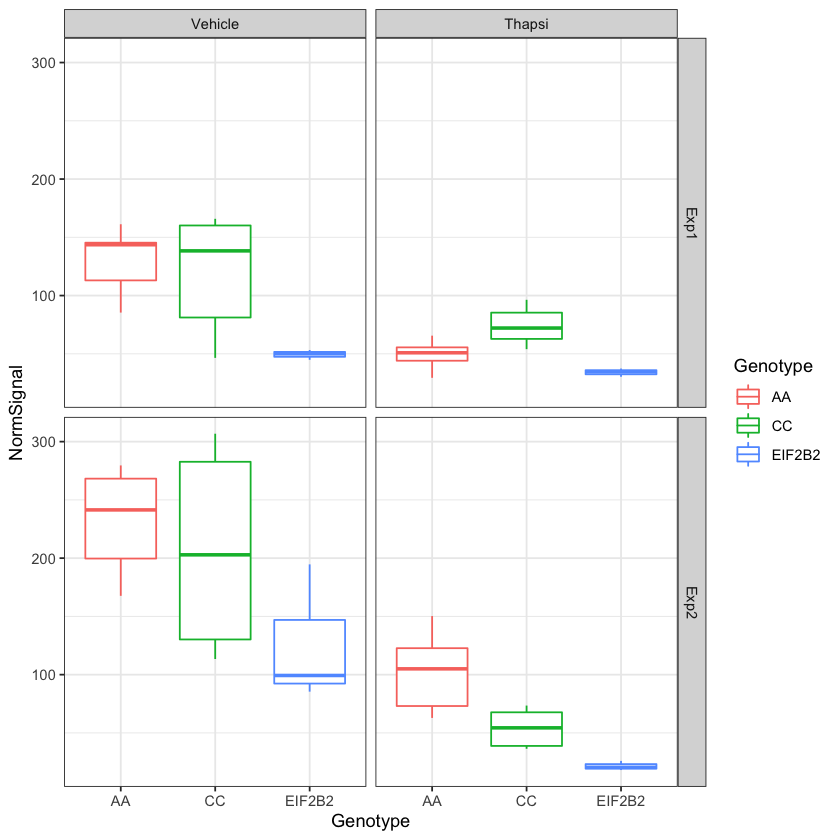

In [112]:
ggplot(df, aes(x=Genotype, y=NormSignal, col=Genotype)) + geom_boxplot() + facet_grid(rows=vars(Experiment), cols=vars(Treatment)) + theme_bw()

In [129]:
lm.full = lmer(NormSignal ~ Genotype * Treatment + (1 | Experiment/Gel/Sample), data = df)

In [130]:
fixef(lm.full)

(Intercept)                     GenotypeCC 
                       181.301                        -17.975 
                GenotypeEIF2B2                TreatmentThapsi 
                       -93.381                       -105.479 
    GenotypeCC:TreatmentThapsi GenotypeEIF2B2:TreatmentThapsi 
                         6.182                         45.359

In [131]:
ranef(lm.full)

$`Sample:(Gel:Experiment)`
               (Intercept)
GM20073:3:Exp1     -0.1290
GM20074:6:Exp2      0.1290
HG01112:1:Exp1     -0.7768
HG01125:2:Exp1    -14.8623
HG01142:2:Exp1     11.4051
HG01435:1:Exp1     -2.0914
HG01565:4:Exp2      4.5729
HG01572:5:Exp2    -13.8866
HG01932:4:Exp2      9.1099
HG02260:5:Exp2      6.5292

$`Gel:Experiment`
       (Intercept)
1:Exp1     -8.5674
2:Exp1    -10.3270
3:Exp1     -0.3854
4:Exp2     40.8716
5:Exp2    -21.9772
6:Exp2      0.3854

$Experiment
     (Intercept)
Exp1      -15.52
Exp2       15.52

with conditional variances for “Sample:(Gel:Experiment)” “Gel:Experiment” “Experiment” 

In [132]:
summary(lm.full)

Linear mixed model fit by REML ['lmerMod']
Formula: NormSignal ~ Genotype * Treatment + (1 | Experiment/Gel/Sample)
   Data: df

REML criterion at convergence: 571.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3974 -0.4909 -0.0135  0.5040  2.3993 

Random effects:
 Groups                  Name        Variance Std.Dev.
 Sample:(Gel:Experiment) (Intercept)  315     17.7    
 Gel:Experiment          (Intercept)  940     30.7    
 Experiment              (Intercept)  757     27.5    
 Residual                            1429     37.8    
Number of obs: 60, groups:  
Sample:(Gel:Experiment), 10; Gel:Experiment, 6; Experiment, 2

Fixed effects:
                               Estimate Std. Error t value
(Intercept)                      181.30      28.48    6.37
GenotypeCC                       -17.97      19.89   -0.90
GenotypeEIF2B2                   -93.38      36.03   -2.59
TreatmentThapsi                 -105.48      15.43   -6.84
GenotypeCC:TreatmentThapsi         6.1

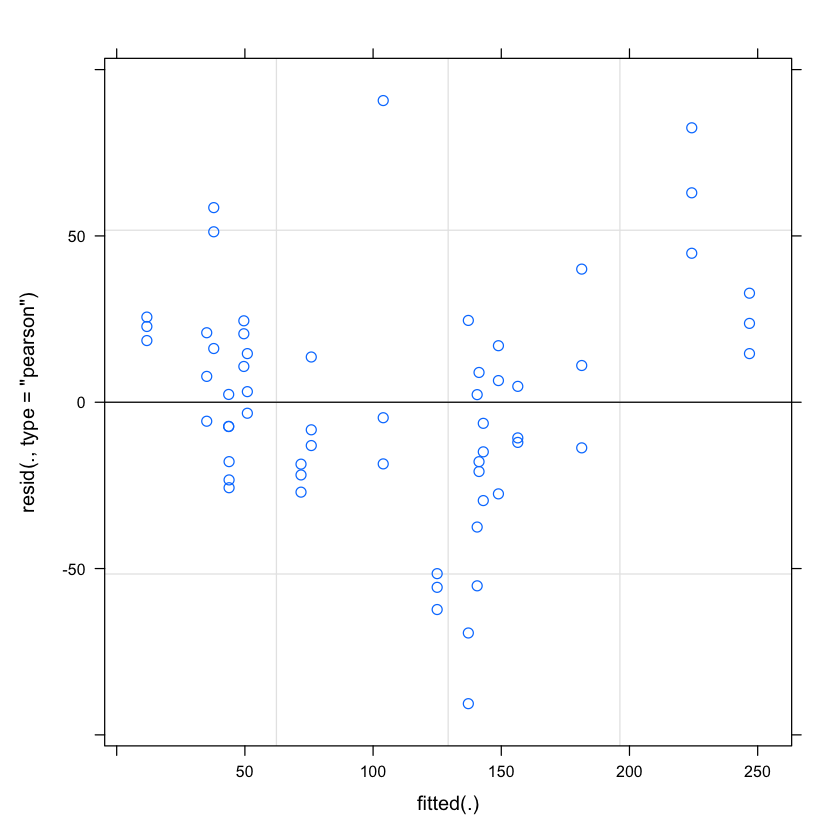

In [133]:
plot(lm.full)

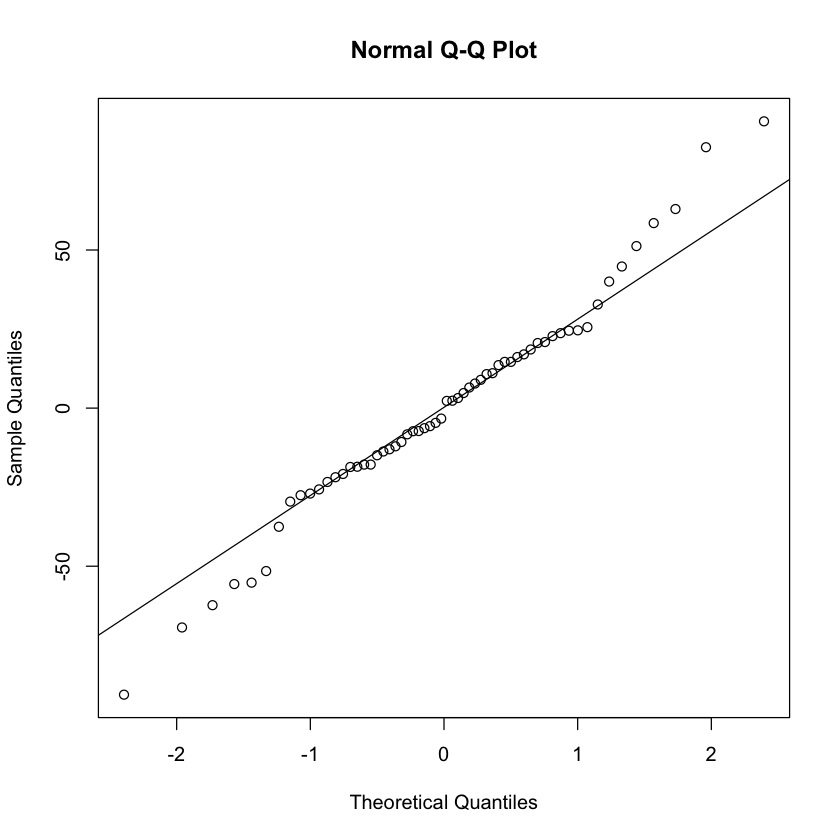

In [134]:
qqnorm(resid(lm.full))
qqline(resid(lm.full))

In [135]:
emmeans(lm.full, list(pairwise ~ Genotype | Treatment), adjust = "tukey")

$`emmeans of Genotype | Treatment`
Treatment = Vehicle:
 Genotype emmean   SE   df lower.CL upper.CL
 AA        181.3 28.5 1.84     47.8      315
 CC        163.3 28.5 1.84     29.8      297
 EIF2B2     87.9 35.3 3.71    -13.1      189

Treatment = Thapsi:
 Genotype emmean   SE   df lower.CL upper.CL
 AA         75.8 28.5 1.84    -57.7      209
 CC         64.0 28.5 1.84    -69.5      198
 EIF2B2     27.8 35.3 3.71    -73.2      129

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of Genotype | Treatment`
Treatment = Vehicle:
 2           estimate   SE   df t.ratio p.value
 AA - CC         18.0 19.9 6.11 0.904   0.6575 
 AA - EIF2B2     93.4 36.0 5.40 2.592   0.0983 
 CC - EIF2B2     75.4 36.0 5.40 2.093   0.1796 

Treatment = Thapsi:
 2           estimate   SE   df t.ratio p.value
 AA - CC         11.8 19.9 6.11 0.593   0.8288 
 AA - EIF2B2     48.0 36.0 5.40 1.333   0.4348 
 CC - EIF2B2     36.2 36.0 5.40 1.006   0.6031 

Degrees-of-free

In [136]:
emmeans(lm.full, list(pairwise ~ Treatment | Genotype), adjust = "tukey")

$`emmeans of Treatment | Genotype`
Genotype = AA:
 Treatment emmean   SE   df lower.CL upper.CL
 Vehicle    181.3 28.5 1.84     47.8      315
 Thapsi      75.8 28.5 1.84    -57.7      209

Genotype = CC:
 Treatment emmean   SE   df lower.CL upper.CL
 Vehicle    163.3 28.5 1.84     29.8      297
 Thapsi      64.0 28.5 1.84    -69.5      198

Genotype = EIF2B2:
 Treatment emmean   SE   df lower.CL upper.CL
 Vehicle     87.9 35.3 3.71    -13.1      189
 Thapsi      27.8 35.3 3.71    -73.2      129

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of Treatment | Genotype`
Genotype = AA:
 2                estimate   SE df t.ratio p.value
 Vehicle - Thapsi    105.5 15.4 47 6.835   <.0001 

Genotype = CC:
 2                estimate   SE df t.ratio p.value
 Vehicle - Thapsi     99.3 15.4 47 6.435   <.0001 

Genotype = EIF2B2:
 2                estimate   SE df t.ratio p.value
 Vehicle - Thapsi     60.1 21.8 47 2.755   0.0083 

Degrees-of-freedom me